In [3]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
import psycopg2

from config import db_password

import time

In [4]:
pd.set_option('display.max_rows', None)

# Extract and Transform Datasets

### <em>World Happiness Report 2021(2021.csv)</em>

In [5]:
# Load the World Happiness Report 2021 dataset.
file_path = "../Resources/2021.csv"
happiness_2021_df = pd.read_csv(file_path)
happiness_2021_df.head(10)

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.0,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.7,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.4,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.0,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.4,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798
5,Norway,Western Europe,7.392,0.035,7.462,7.323,11.053,0.954,73.3,0.960,0.093,0.270,2.43,1.543,1.108,0.782,0.703,0.249,0.427,2.580
6,Sweden,Western Europe,7.363,0.036,7.433,7.293,10.867,0.934,72.7,0.945,0.086,0.237,2.43,1.478,1.062,0.763,0.685,0.244,0.448,2.683
7,Luxembourg,Western Europe,7.324,0.037,7.396,7.252,11.647,0.908,72.6,0.907,-0.034,0.386,2.43,1.751,1.003,0.760,0.639,0.166,0.353,2.653
8,New Zealand,North America and ANZ,7.277,0.040,7.355,7.198,10.643,0.948,73.4,0.929,0.134,0.242,2.43,1.400,1.094,0.785,0.665,0.276,0.445,2.612
9,Austria,Western Europe,7.268,0.036,7.337,7.198,10.906,0.934,73.3,0.908,0.042,0.481,2.43,1.492,1.062,0.782,0.640,0.215,0.292,2.784


In [4]:
#Note: The choice of Dystopia as a benchmark permits every real country to
    #have a positive (or at least zero) contribution from each of the six factors.
    #Since our objective is to fit the best predictive model, we should not use Dystopia.

In [6]:
# Drop unnecessary columns from the DataFrame.
hpp_clean_df = happiness_2021_df.drop(['Regional indicator', 'Standard error of ladder score','upperwhisker', 'lowerwhisker',
                                         'Ladder score in Dystopia', 'Explained by: Log GDP per capita',
                                         'Explained by: Social support', 'Explained by: Healthy life expectancy',
                                         'Explained by: Freedom to make life choices', 'Explained by: Generosity',
                                         'Explained by: Perceptions of corruption', 'Dystopia + residual'], axis = 1)

# Rename column 'Ladder score' to 'Happiness score'.
hpp_clean_df = hpp_clean_df.rename(columns = {'Ladder score':'Happiness score'})
print(hpp_clean_df.shape)
hpp_clean_df.head(10)

(149, 8)


,Country name,Happiness score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338
5,Norway,7.392,11.053,0.954,73.3,0.960,0.093,0.270
6,Sweden,7.363,10.867,0.934,72.7,0.945,0.086,0.237
7,Luxembourg,7.324,11.647,0.908,72.6,0.907,-0.034,0.386
8,New Zealand,7.277,10.643,0.948,73.4,0.929,0.134,0.242
9,Austria,7.268,10.906,0.934,73.3,0.908,0.042,0.481


In [7]:
# Check column types.
hpp_clean_df.dtypes

Country name                     object
Happiness score                 float64
Logged GDP per capita           float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

In [9]:
# Check null values.
hpp_clean_df.isnull().sum()

Country name                    0
Happiness score                 0
Logged GDP per capita           0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

In [10]:
# do a df.describe() on "Happiness score"
hpp_clean_df["Happiness score"].describe()

count    149.000000
mean       5.532839
std        1.073924
min        2.523000
25%        4.852000
50%        5.534000
75%        6.255000
max        7.842000
Name: Happiness score, dtype: float64

#### Create binary column "IS_HAPPY"
- to be utilized in the future for Machine Learning Model(unsupervised)

In [12]:
# create "IS_HAPPY" column (binary outputs [Yes:1, No:0])

happy = []

for value in hpp_clean_df["Happiness score"]:
    if value >= 5.5:
        happy.append(1)
    elif value < 5.5:
        happy.append(0)

# Add column to dataframe then inspect afterwards

hpp_clean_df["IS_HAPPY"] = happy

hpp_clean_df.head(10)

,Country name,Happiness score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,IS_HAPPY
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,1
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179,1
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292,1
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673,1
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338,1
5,Norway,7.392,11.053,0.954,73.3,0.960,0.093,0.270,1
6,Sweden,7.363,10.867,0.934,72.7,0.945,0.086,0.237,1
7,Luxembourg,7.324,11.647,0.908,72.6,0.907,-0.034,0.386,1
8,New Zealand,7.277,10.643,0.948,73.4,0.929,0.134,0.242,1
9,Austria,7.268,10.906,0.934,73.3,0.908,0.042,0.481,1


In [15]:
# Re-name column to ensure merge later on
hpp_clean_df.rename(columns = {'Country name':'Country'}, inplace = True)
hpp_clean_df.head()

,Country,Happiness score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,IS_HAPPY
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,1
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179,1
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292,1
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673,1
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338,1


In [13]:
hpp_clean_df["IS_HAPPY"].value_counts()

1    75
0    74
Name: IS_HAPPY, dtype: int64

## Country Coordinates(country-coordinates-world.csv)

In [14]:
# Load the country coordinates dataset.
file_path = "../Resources/country-coordinates-world.csv"
country_coordinates_df = pd.read_csv(file_path)
country_coordinates_df

,latitude,longitude,Country
0,33.939110,67.709953,Afghanistan
1,41.153332,20.168331,Albania
2,28.033886,1.659626,Algeria
3,-14.270972,-170.132217,American Samoa
4,42.546245,1.601554,Andorra
5,-11.202692,17.873887,Angola
6,18.220554,-63.068615,Anguilla
7,-75.250973,-0.071389,Antarctica
8,17.060816,-61.796428,Antigua and Barbuda
9,-38.416097,-63.616672,Argentina


In [ ]:
# Load the Mortality Report dataset from the World Happiness Report 2021.
file_path = "../Resources/MortalityDataWHR2021C2.csv"
mortality_df = pd.read_csv(file_path)

# Re-name column to ensure merge later on
mortality_df.rename(columns = {'Country name':'Country'}, inplace = True)
mortality_df.head()

# Display
mortality_df.head(10)

In [13]:
# Extract necessray columns and make a new Dataframe.
gini_index = mortality_df[['Country name', 'Index of institutional trust', 'Gini coefficient of income']]
gini_index.head(10)

,Country name,Index of institutional trust,Gini coefficient of income
0,United States,0.250,47.510
1,Egypt,0.446,31.560
2,Morocco,0.397,39.550
3,Lebanon,0.107,31.830
4,Saudi Arabia,0.651,45.900
5,Jordan,0.465,33.100
6,Syria,0.319,34.200
7,Turkey,0.295,40.550
8,Pakistan,0.277,33.450
9,Indonesia,0.561,37.478


In [14]:
# Replace country name to match with 'happiness_df'.
gini_index["Country name"].replace('Eswatini','Swaziland', inplace=True)
print(gini_index.shape)
gini_index.head(10)

(166, 3)


,Country name,Index of institutional trust,Gini coefficient of income
0,United States,0.250,47.510
1,Egypt,0.446,31.560
2,Morocco,0.397,39.550
3,Lebanon,0.107,31.830
4,Saudi Arabia,0.651,45.900
5,Jordan,0.465,33.100
6,Syria,0.319,34.200
7,Turkey,0.295,40.550
8,Pakistan,0.277,33.450
9,Indonesia,0.561,37.478


In [15]:
# Check null values.
gini_index.isnull().sum()

Country name                    0
Index of institutional trust    1
Gini coefficient of income      2
dtype: int64

In [16]:
# Load the unemployment 2021 dataset from World Bank data.
file_path = "Resources/Unemployment_data_2021.csv"
country_unempl_df = pd.read_csv(file_path)
country_unempl_df.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.562179,6.445456,6.405196,6.490041,6.610205,6.714955,6.731163,6.914353,7.563187,8.111783
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,11.341000,11.193000,11.142000,11.127000,11.158000,11.180000,11.152000,11.217000,11.710000,13.283000
3,Africa Western and Central,AFW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.637602,4.410216,4.688088,4.626737,5.567017,6.019505,6.041092,6.063362,6.774914,6.839009
4,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.347000,7.366000,7.372000,7.392000,7.412000,7.408000,7.421000,7.421000,8.333000,8.530000
5,Albania,ALB,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,13.380000,15.870000,18.049999,17.190001,15.420000,13.620000,12.300000,11.470000,13.329000,11.819000
6,Andorra,AND,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arab World,ARB,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,10.663129,10.735393,10.872227,10.965901,10.761115,10.896379,10.502336,10.006154,11.487321,11.625344
8,United Arab Emirates,ARE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,2.185000,2.044000,1.911000,1.768000,1.640000,2.460000,2.352000,2.230000,3.188000,3.358000
9,Argentina,ARG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.220000,7.100000,7.270000,7.521000,8.111000,8.350000,9.220000,9.840000,11.460000,10.902000


In [17]:
# Extract necessary columns and make a new DataFrame.
unempl_df = country_unempl_df[['Country Name', '2021']]
#unempl_df.head()

# Rename columns.
country_unempl_df = unempl_df.rename(columns = {'Country Name':'Country name', '2021':'Unemployment rate'})
#country_unempl_df

# Replace country name to match with 'happiness_df'.
country_unempl_df["Country name"].replace(['Slovak Republic', 'Korea, Rep.','Kyrgyz Republic','Russian Federation','Hong Kong SAR, China','Congo, Rep.',
                                           "Cote d'Ivoire",'Gambia, The','Lao PDR','Venezuela, RB','Eswatini','Iran, Islamic Rep.','Egypt, Arab Rep.',
                                          'Yemen, Rep.'], 
                                          ['Slovakia','South Korea','Kyrgyzstan','Russia','Hong Kong S.A.R. of China',"Congo (Brazzaville)",'Ivory Coast','Gambia',
                                           'Laos','Venezuela','Swaziland','Iran','Egypt', 'Yemen'], inplace = True)
print(country_unempl_df.shape)
country_unempl_df.head(10)

(266, 2)


,Country name,Unemployment rate
0,Aruba,NaN
1,Africa Eastern and Southern,8.111783
2,Afghanistan,13.283000
3,Africa Western and Central,6.839009
4,Angola,8.530000
5,Albania,11.819000
6,Andorra,NaN
7,Arab World,11.625344
8,United Arab Emirates,3.358000
9,Argentina,10.902000


In [ ]:
# Initial imports
import pandas as pd
import plotly.express as px
import hvplot.pandas
from path import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# Merge 'happiness_df' and 'country_unempl_df' with left join.
happy_unempl = pd.merge(hppiness_df,country_unempl_df, how='left' )
happy_unempl.head(10)

,Country name,Happiness score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,IS_HAPPY,Unemployment rate
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,1,7.525
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179,1,4.798
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292,1,5.321
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673,1,5.401
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338,1,4.010
5,Norway,7.392,11.053,0.954,73.3,0.960,0.093,0.270,1,4.985
6,Sweden,7.363,10.867,0.934,72.7,0.945,0.086,0.237,1,8.661
7,Luxembourg,7.324,11.647,0.908,72.6,0.907,-0.034,0.386,1,5.227
8,New Zealand,7.277,10.643,0.948,73.4,0.929,0.134,0.242,1,4.124
9,Austria,7.268,10.906,0.934,73.3,0.908,0.042,0.481,1,6.301


In [19]:
# Check if any missing values.
happy_unempl.isnull().sum()

# Drop all the missing values from 'Unemployment rate' column.
happy_unempl_cln = happy_unempl.dropna(subset = ["Unemployment rate"])
print(happy_unempl_cln.shape)
happy_unempl_cln.head(10)

(145, 10)


,Country name,Happiness score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,IS_HAPPY,Unemployment rate
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,1,7.525
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179,1,4.798
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292,1,5.321
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673,1,5.401
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338,1,4.010
5,Norway,7.392,11.053,0.954,73.3,0.960,0.093,0.270,1,4.985
6,Sweden,7.363,10.867,0.934,72.7,0.945,0.086,0.237,1,8.661
7,Luxembourg,7.324,11.647,0.908,72.6,0.907,-0.034,0.386,1,5.227
8,New Zealand,7.277,10.643,0.948,73.4,0.929,0.134,0.242,1,4.124
9,Austria,7.268,10.906,0.934,73.3,0.908,0.042,0.481,1,6.301


In [20]:
# Check if any missing values in the cleaned DataFrame.
happy_unempl_cln.isnull().sum()

Country name                    0
Happiness score                 0
Logged GDP per capita           0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
IS_HAPPY                        0
Unemployment rate               0
dtype: int64

In [21]:
# Merge DataFrames'happy_unempl_cln' and 'gini_index' with left join.
hppiness_final = pd.merge(happy_unempl_cln, gini_index, how='left' )
print(hppiness_final.shape)
hppiness_final.head(10)

(145, 12)


,Country name,Happiness score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,IS_HAPPY,Unemployment rate,Index of institutional trust,Gini coefficient of income
0,Finland,7.842,10.775,0.954,72.0,0.949,-0.098,0.186,1,7.525,0.550,25.9
1,Denmark,7.620,10.933,0.954,72.7,0.946,0.030,0.179,1,4.798,0.572,27.8
2,Switzerland,7.571,11.117,0.942,74.4,0.919,0.025,0.292,1,5.321,0.660,30.1
3,Iceland,7.554,10.878,0.983,73.0,0.955,0.160,0.673,1,5.401,0.325,24.1
4,Netherlands,7.464,10.932,0.942,72.4,0.913,0.175,0.338,1,4.010,0.522,27.0
5,Norway,7.392,11.053,0.954,73.3,0.960,0.093,0.270,1,4.985,0.606,24.8
6,Sweden,7.363,10.867,0.934,72.7,0.945,0.086,0.237,1,8.661,0.451,27.0
7,Luxembourg,7.324,11.647,0.908,72.6,0.907,-0.034,0.386,1,5.227,0.595,30.9
8,New Zealand,7.277,10.643,0.948,73.4,0.929,0.134,0.242,1,4.124,0.527,34.1
9,Austria,7.268,10.906,0.934,73.3,0.908,0.042,0.481,1,6.301,0.358,26.8


In [22]:
# Check if any missing values.
hppiness_final.isnull().sum()

Country name                    0
Happiness score                 0
Logged GDP per capita           0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
IS_HAPPY                        0
Unemployment rate               0
Index of institutional trust    0
Gini coefficient of income      0
dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

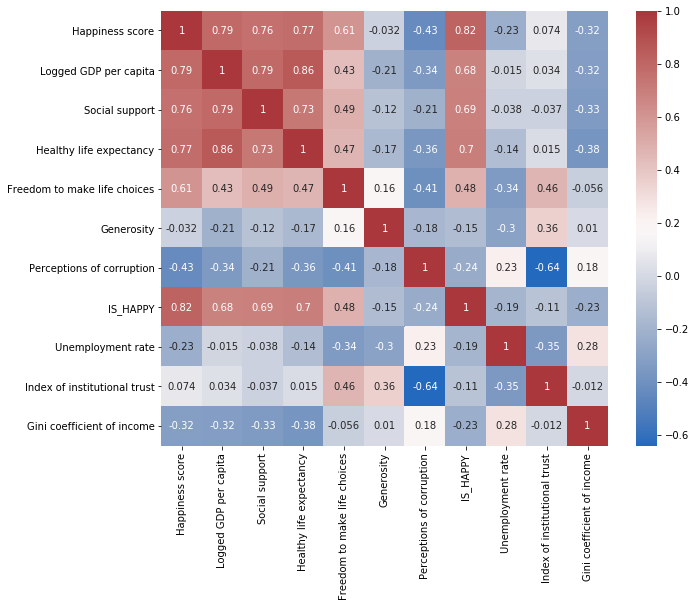

In [23]:
#print(hpp_unempl_gini.corr())
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 8))
# plotting correlation heatmap
#dataplot = sb.heatmap(hpp_unempl_gini.corr(), cmap="rocket_r", annot=True, ax=ax)
dataplot = sns.heatmap(hppiness_final.corr(), cmap="vlag", annot=True, ax=ax)
  
# displaying heatmap
plt.show

In [26]:
# # Export data(for further manipulation if need be)

# hppiness_df.to_csv('Export_files/happiness_report_2021.csv',index = False, header=True)

# country_unempl_df.to_csv('Export_files/unemployment_2021.csv',index = False, header=True)

# gini_index.to_csv('Export_files/gini_index_2021.csv',index = False, header=True)